## Exploratory Data Analysis (EDA)

This notebook examines the time series data and the computed statistics.

This notebook runs using the standard ml environment

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the 100 day .npy file
data_path = 'data/ai_ready'
file_name = '100_days.npy'
full_path = os.path.join(data_path, file_name)
time_series = np.load(full_path)

# Load the data from the statistics file
filepath = '/'.join(os.getcwd().split('/')) + '/data/ai_ready/statistics.csv'
df = pd.read_csv(filepath_or_buffer=filepath)
df.head(3)

,mean,max,min,median,range,std,var,spec_mean,spec_max,spec_min,...,spec_std,spec_var,speclog_mean,speclog_max,speclog_min,speclog_median,speclog_range,speclog_std,speclog_var,state
0,-2.045739,1659.079530,-1318.335883,-6.963337,2977.415414,371.791134,138228.647271,10.392417,995.277247,0.004666,...,31.456352,989.502099,0.433941,2.997944,-2.331057,0.297929,5.329001,0.661548,0.437646,before
1,-43.245231,1800.918051,-1867.272921,-56.748376,3668.190972,476.115885,226686.335511,12.038669,1081.727088,0.010802,...,40.854324,1669.075788,0.473613,3.034118,-1.966483,0.329268,5.000601,0.658096,0.433090,before
2,-34.465366,2031.091640,-2252.112966,-32.267577,4283.204606,548.338617,300675.238931,12.984918,1236.088867,0.011445,...,49.401049,2440.463664,0.500578,3.092050,-1.941383,0.366436,5.033433,0.640550,0.410304,before


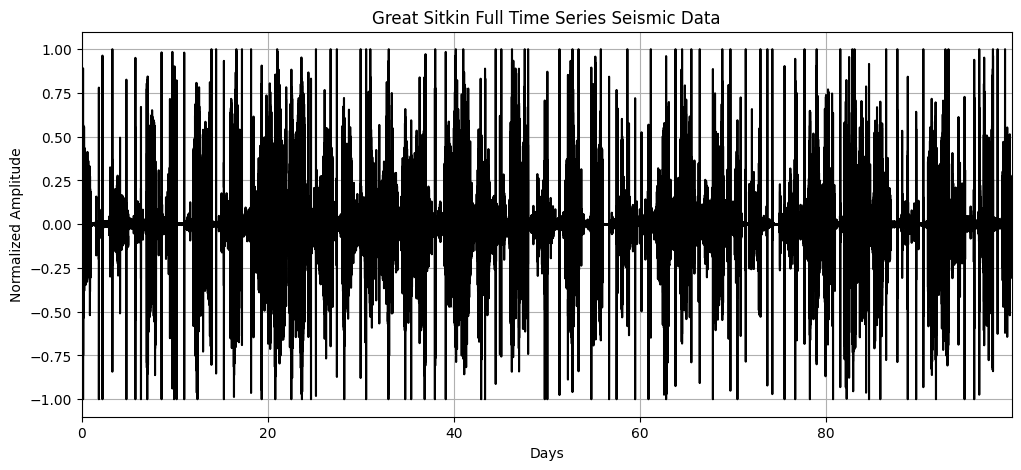

In [10]:
#plot full time series array
plt.figure(figsize=(12,5))
time = np.arange(len(time_series))
time = time / (8*60*60*24) #converting from 8 Hz to days

plt.plot(time, time_series, c='k')
plt.xlim(0, max(time))
plt.xlabel('Days')
plt.ylabel('Normalized Amplitude')
plt.title('Great Sitkin Full Time Series Seismic Data')
plt.grid();

Nothing seems wildly out of place with this time series. It is clearly seismically active, and none of the spikes seem nonphysical in shape. (Time series plots were created for each day of data in the earlier data cleaning notebook and thus the visual inspectual here is cursory).

### Look at distributions of statistics

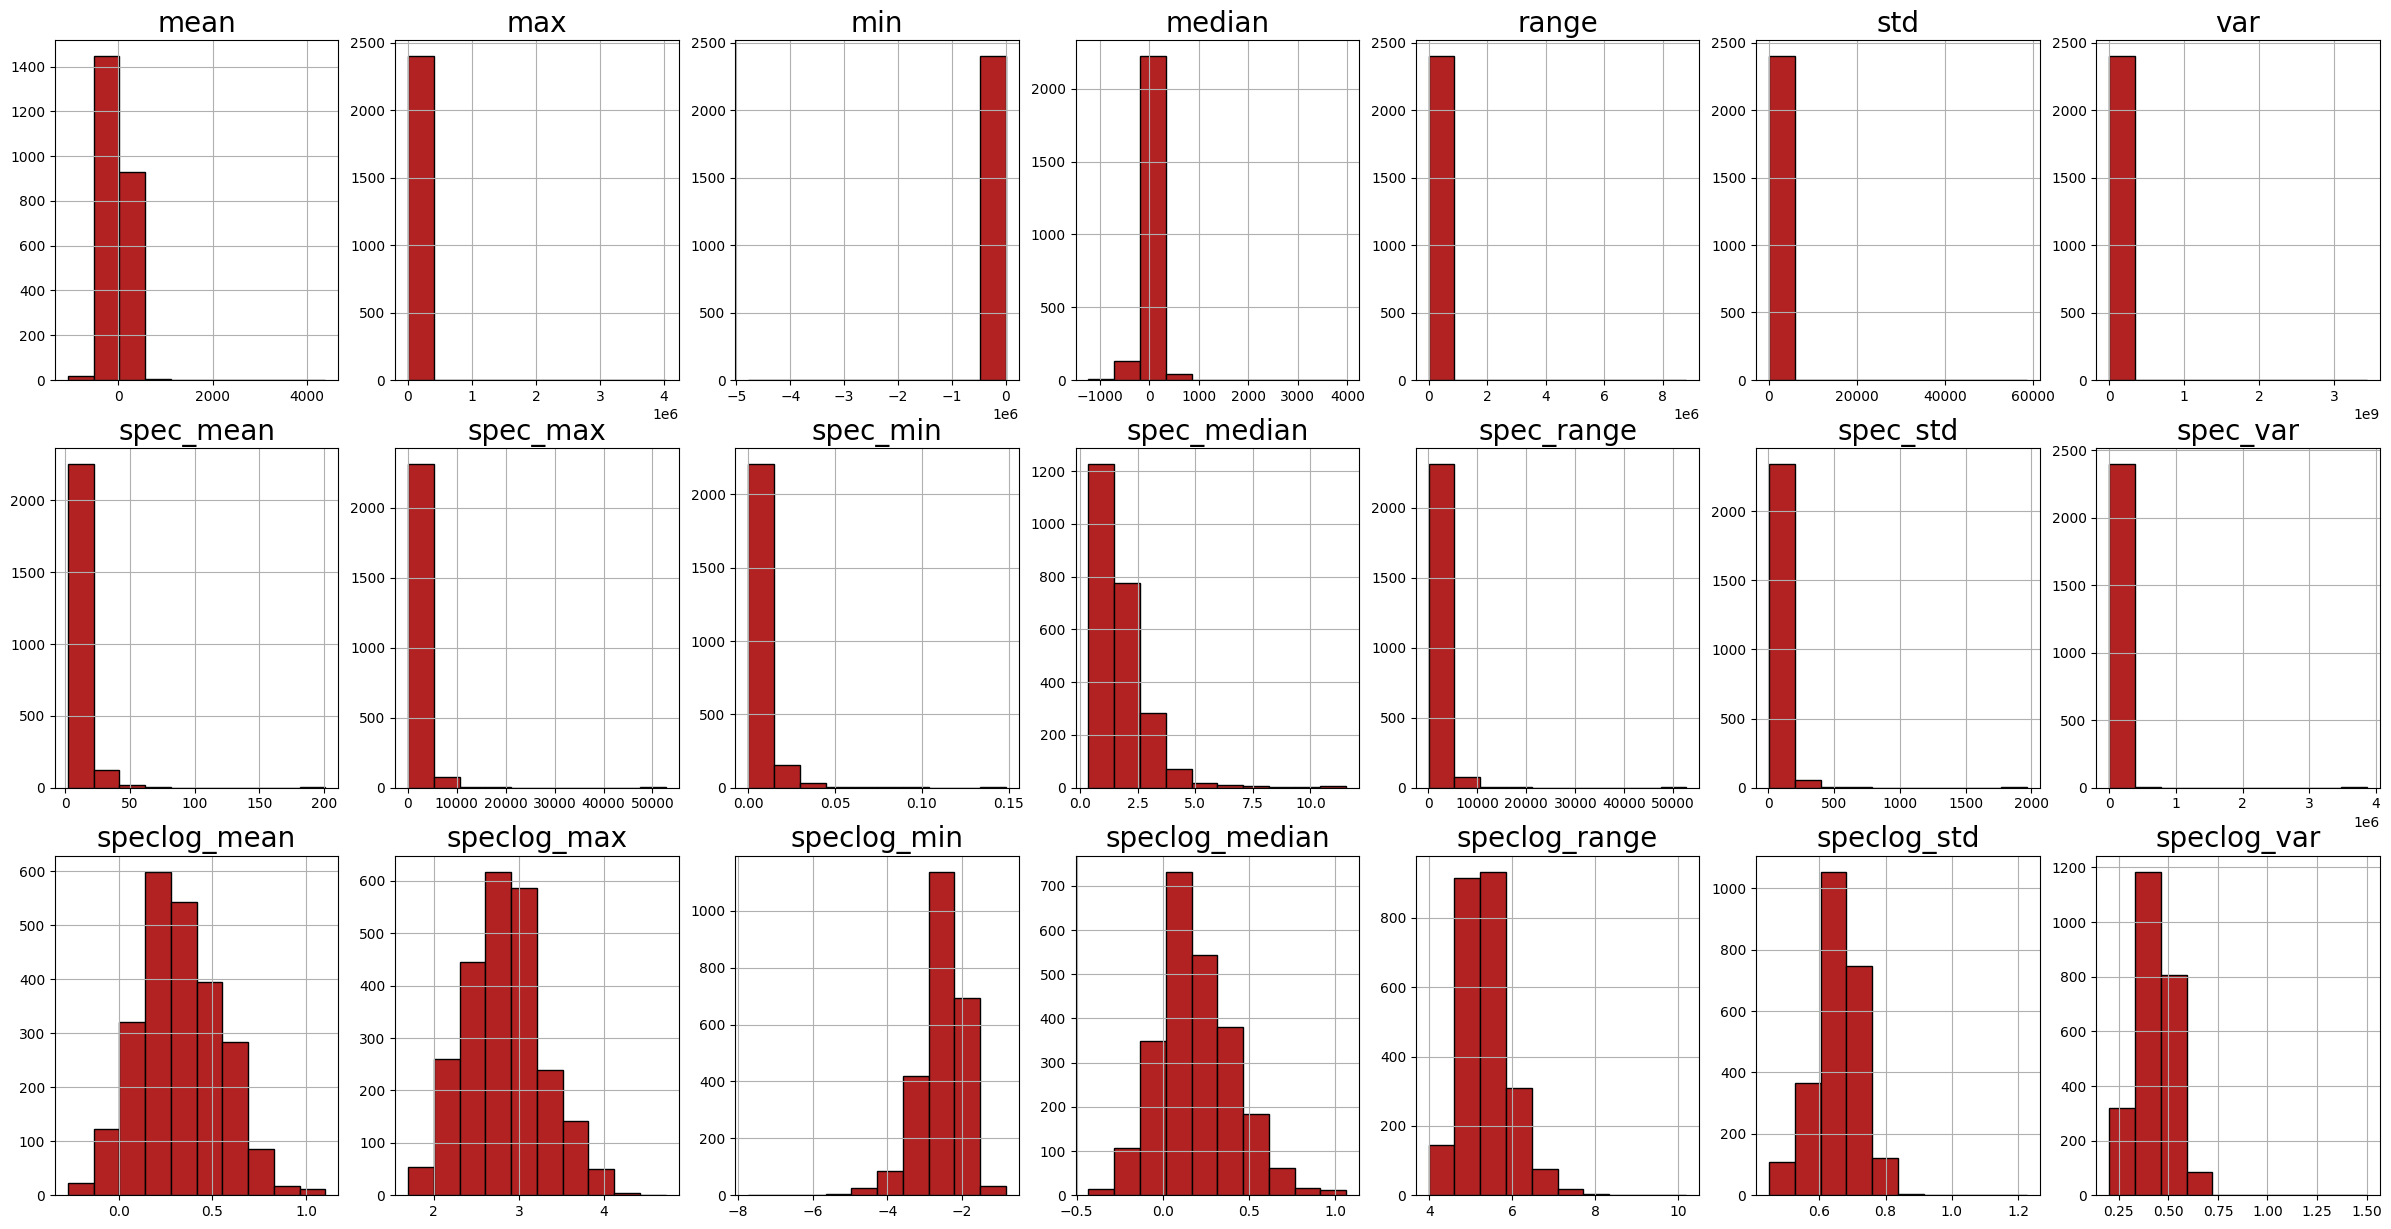

In [3]:
keys = df.keys()[0:-1]
fig, axs = plt.subplots(nrows = 3, ncols= 7)
fig.set_size_inches(30,15)

for i in np.arange(len(keys)):
    hor_ind = i%7
    vert_ind = int(i/7)
    key = keys[i]
    ax = axs[vert_ind][hor_ind]
    data = df[key]

    ax.hist(data, color='firebrick', edgecolor='k')
    ax.set_title(key, fontsize=20)
    ax.grid()

The linear time series and spectral characteristics are skewed by large amplitude outliers, which have each been identified and found to be physical events, at least by appearance. For example, the largest amplitude recorded, 400,000 counts, occurs on day 97 and appears to be from an impact near the sensor. These outliers were left in given their seemingly physical nature, and given that eruption event are necessarily extreme and thus expected to stand out from the background signal.

### Compute Correlation Matrix of Stats

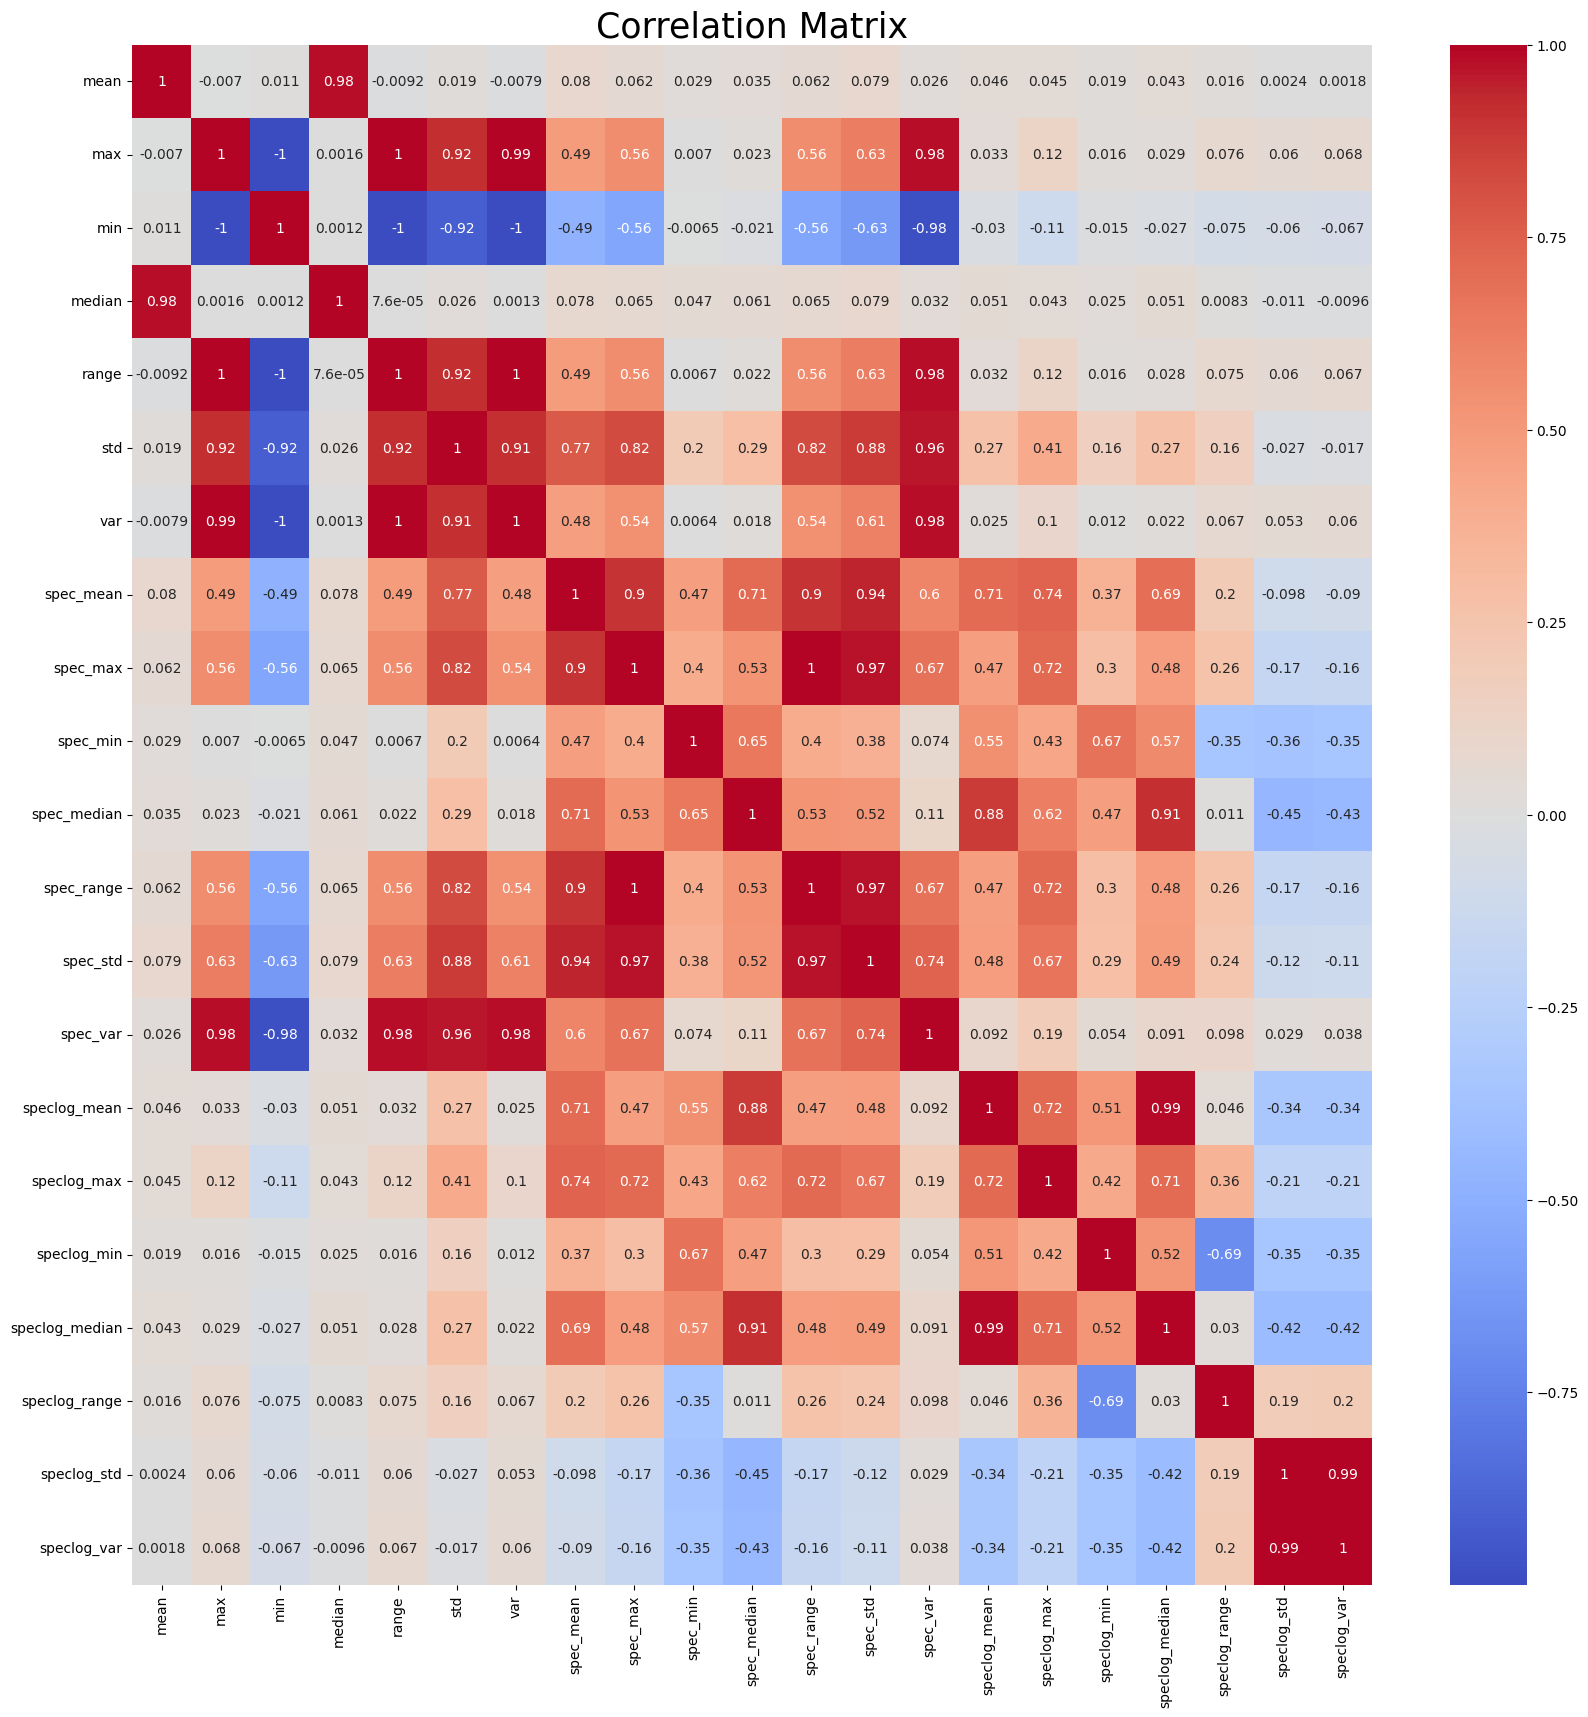

In [7]:
plt.figure(figsize=(20,20))
sns.heatmap(df.drop(columns=['state']).corr(), cmap='coolwarm', center=0, annot=True)
plt.title('Correlation Matrix', fontsize=25);

Many of the stats, especially in spectral log space, are quite independent of each other. However, there are still quite a few correlations, implying this dataset could be dimensionality reduced using a method like principal component analysis.

### Compute overall spectra and spectrogram of data

/var/folders/jz/1_5zh2bj42bb_8hlyhd9lfxw0000gn/T/ipykernel_23494/3099298411.py:24: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(np.min(f), np.max(f))


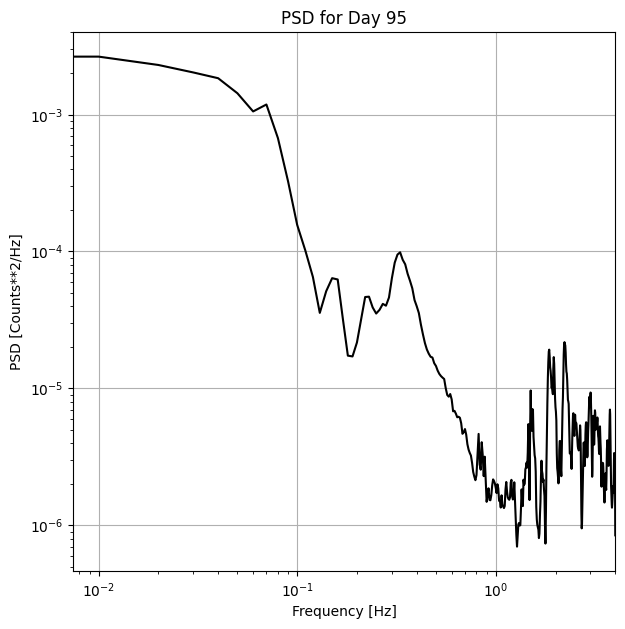

In [11]:
from scipy import signal

#load day of data
data_path = 'data/ai_ready'
file_name = '95_ready.npy'
full_path = os.path.join(data_path, file_name)
data = np.load(full_path)

#compute power spectral density using Welch's Method
fs = 8 #sampling rate in hz
window = 10*10 #second window to compute ffts over, at least 10x the period of the lowest freq you care about

#generate a Tukey window to taper the data with
taper = signal.windows.tukey(len(data))

#welch returns frequency and power given a signal and sampling rate
f, Pxx_den = signal.welch(data*taper, fs, nperseg=window*fs)

plt.figure(figsize=(7,7))
plt.loglog(f, Pxx_den, color='k')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [Counts**2/Hz]')
plt.title('PSD for Day '+file_name.split('_')[0])
plt.xlim(np.min(f), np.max(f))
plt.grid();

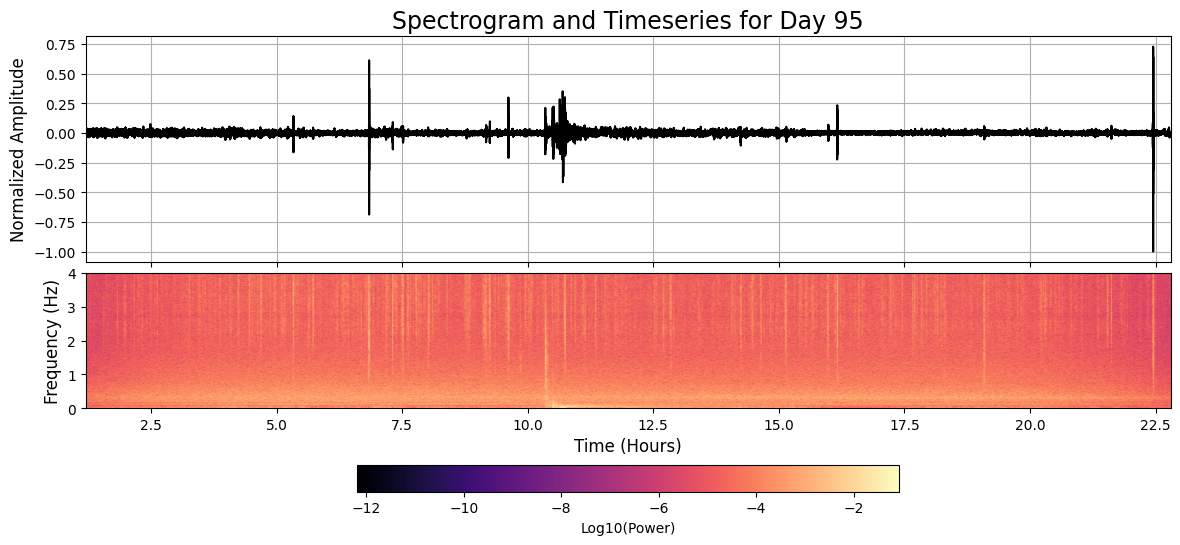

In [12]:
#plot spectrogram
fs = 8
window = 10*10

#generate a Tukey window to taper the data with
taper = signal.windows.tukey(len(data))

#compute the spectrogram
f, t, Zxx = signal.stft(taper*data, fs=fs, nperseg=window*fs, noverlap=200)
t /= 3600 #time in hours

#plot
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.set_size_inches(14,6)
fig.subplots_adjust(hspace=0.05)

plot_time = np.arange(len(data)) / (3600*fs) #time in hours
axs[0].plot(plot_time, data, c='k')
axs[0].grid()
axs[0].set_ylabel('Normalized Amplitude', fontsize=12)

cax = axs[1].pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud', cmap='magma')
fig.colorbar(cax, label='Log10(Power)', shrink=0.5, location='bottom', pad=0.25)
axs[1].set_xlabel('Time (Hours)', fontsize=12)
axs[1].set_ylabel('Frequency (Hz)', fontsize=12)

#chop off tapers (not ideal solution, but works for visuals)
buffer = 24*0.05
axs[0].set_xlim(buffer, 24-buffer)
axs[1].set_xlim(buffer, 24-buffer)

axs[0].set_title('Spectrogram and Timeseries for Day '+str(file_name).split('_')[0], fontsize=17);

### Conclusion <br>

This introductory analysis shows that our data is more or less evenly distributed around 0, as expected, and has a large standard deviation, owing to its signal fluctuating wildly between extreme values. The frequency analysis shows that much of the signal's energy is concentrated below 1 Hz, again as expected.

Due to the presence of physical outliers in the data, the log-transformed statistics are easier to visualize than the linear ones.